## Demo - Reconstructing a color image using PCA

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

Red channel shape: (1000, 1000)
Green channel shape: (1000, 1000)
Blue channel shape: (1000, 1000)


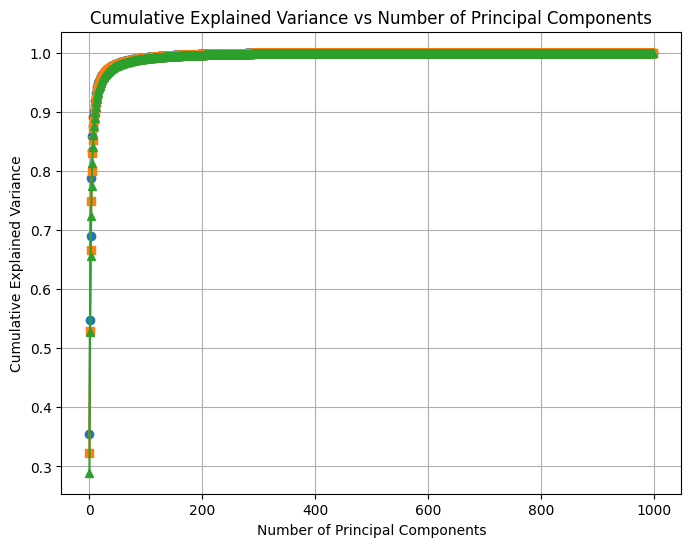

In [44]:
basefolder = '/Users/fp/GitHub Repos/UNISA-Vault/MastersDegree/Data Science/Exercises/Python scripts/'
image = Image.open(f'{basefolder}doggo.jpeg')

image = image.resize((1000, 1000))              # resizing image to 1000x1000 pixels
image_array = np.array(image)                   # convert image to numpy array

X_red = image_array[:,:,0]                      # red channel
X_green = image_array[:,:,1]                    # green channel
X_blue = image_array[:,:,2]                     # blue channel

print(f"Red channel shape: {X_red.shape}")
print(f"Green channel shape: {X_green.shape}")
print(f"Blue channel shape: {X_blue.shape}")

# for each channel, we have 1000 observations (rows) and 1000 features (columns)
# we will apply PCA to each channel separately

pca_red = PCA().fit(X_red)
pca_green = PCA().fit(X_green)
pca_blue = PCA().fit(X_blue)

var_red = np.cumsum(pca_red.explained_variance_ratio_)  # cumulative explained variance for red channel
var_green = np.cumsum(pca_green.explained_variance_ratio_)  # cumulative explained variance for green channel
var_blue = np.cumsum(pca_blue.explained_variance_ratio_)  # cumulative explained variance for blue channel

plt.figure(figsize=(8, 6))
plt.plot(var_red, marker='o', label='Red Channel')
plt.plot(var_green, marker='s', label='Green Channel')
plt.plot(var_blue, marker='^', label='Blue Channel')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.grid()
plt.show()


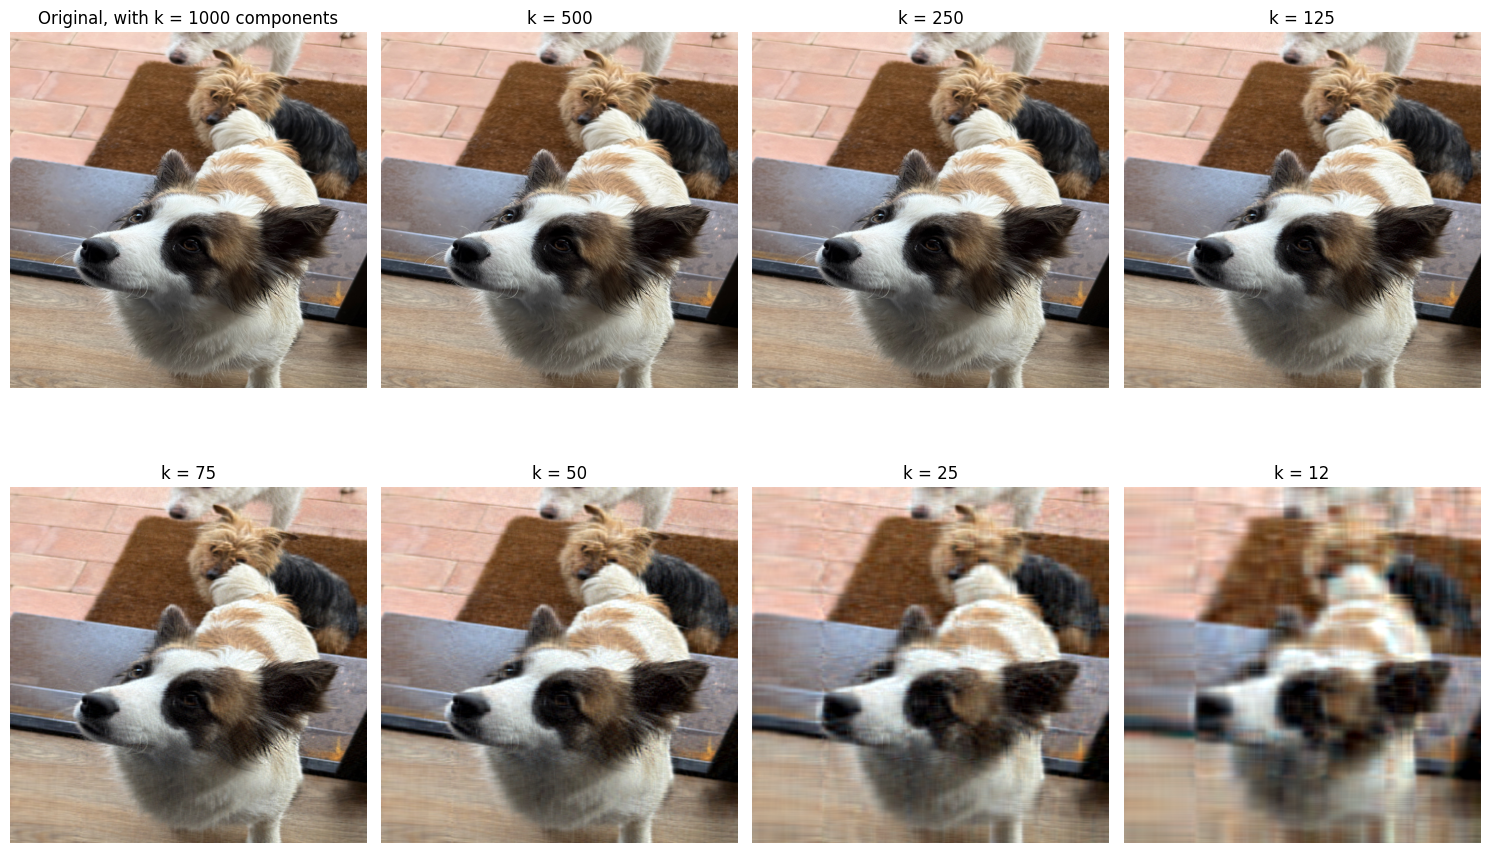

In [ ]:
# reduce dimensionality across several k values with less repetition
ks = [500, 250, 125, 75, 50, 25, 12]
positions = [2, 3, 4, 5, 6, 7, 8]

plt.subplots(2, 4, figsize=(15, 10))

# original image
plt.subplot(2, 4, 1)
plt.imshow(image)
plt.title(f"Original, with k = {X_red.shape[1]} components")
plt.axis("off")

def reconstruct_channel(X, k):
  pca = PCA(n_components=k)
  return pca.inverse_transform(pca.fit_transform(X))

for k, pos in zip(ks, positions):
  img_red_k = reconstruct_channel(X_red, k)
  img_green_k = reconstruct_channel(X_green, k)
  img_blue_k = reconstruct_channel(X_blue, k)

  img_k = np.stack((img_red_k, img_green_k, img_blue_k), axis=2)
  img_k = np.clip(img_k, 0, 255).astype(np.uint8)  # ensure pixel RGB values are in the valid range, before casting to a 8-bit unsigned integer value

  plt.subplot(2, 4, pos)
  plt.imshow(img_k)
  plt.title(f"k = {k}")
  plt.axis("off")

plt.tight_layout()
plt.show()


Number of components for red channel to explain 95.0% variance: 18
Number of components for green channel to explain 95.0% variance: 20
Number of components for blue channel to explain 95.0% variance: 22


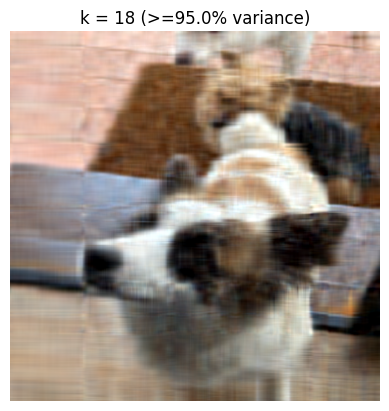

In [ ]:
# what if I ask for a k value which explains at least 95% of the variance?

pve = 0.95

pca_red_pve = PCA(n_components=pve, svd_solver='full').fit(X_red)
pca_green_pve = PCA(n_components=pve, svd_solver='full').fit(X_green)
pca_blue_pve = PCA(n_components=pve, svd_solver='full').fit(X_blue)

print(f"Number of components for red channel to explain {pve*100}% variance: {pca_red_pve.n_components_}")
print(f"Number of components for green channel to explain {pve*100}% variance: {pca_green_pve.n_components_}")
print(f"Number of components for blue channel to explain {pve*100}% variance: {pca_blue_pve.n_components_}")

k = min(pca_red_pve.n_components_, pca_green_pve.n_components_, pca_blue_pve.n_components_)
img_red_k = reconstruct_channel(X_red, k)
img_green_k = reconstruct_channel(X_green, k)
img_blue_k = reconstruct_channel(X_blue, k)

img_k = np.stack((img_red_k, img_green_k, img_blue_k), axis=2)
img_k = np.clip(img_k, 0, 255).astype(np.uint8)  # ensure pixel RGB values are in the valid range

plt.imshow(img_k)
plt.title(f"k = {k} (>={pve*100}% variance)")
plt.axis("off")
plt.show()

Ok, it works pretty well...
...but what if I implement this by scratch? Without using scikit-learn library, and using only numpy?

Let's do this.

Covariance matrix of T_red (should be diagonal with eigenvalues):
[[ 1.30283894e+06  1.20145925e-10 -2.83913425e-10 ... -3.22636648e-11
   1.94669080e-12  4.60881487e-11]
 [ 1.20145925e-10  7.05637740e+05  1.75175455e-10 ... -1.15540471e-11
   1.01808720e-12  1.56696155e-11]
 [-2.83913425e-10  1.75175455e-10  5.17496200e+05 ...  2.19450683e-11
   1.05421449e-11 -1.68165311e-11]
 ...
 [-3.22636648e-11 -1.15540471e-11  2.19450683e-11 ...  8.08043463e-06
   8.08336674e-13 -7.96339774e-13]
 [ 1.94669080e-12  1.01808720e-12  1.05421449e-11 ...  8.08336674e-13
   3.05413059e-08  1.57382862e-12]
 [ 4.60881487e-11  1.56696155e-11 -1.68165311e-11 ... -7.96339774e-13
   1.57382862e-12  8.18753075e-17]]

Covariance matrix of T_green (should be diagonal with eigenvalues):
[[ 1.06521865e+06 -2.64443777e-10  1.44499468e-11 ...  1.24501125e-11
  -5.07331628e-11  7.24094660e-12]
 [-2.64443777e-10  6.83964590e+05  2.32558396e-10 ... -5.13581062e-12
  -2.55474976e-11 -1.07478323e-11]
 [ 1.44499468e-11  

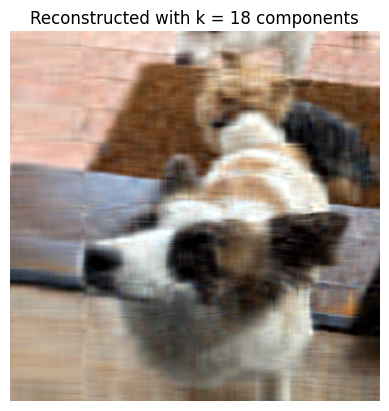

In [57]:
# let's center the data matrices for each channel by subtracting the mean of each column (feature) from the corresponding column values,
# so that we can compute the covariance matrix and eigenvalues/eigenvectors for PCA

mu_red = np.mean(X_red, axis=0)
mu_green = np.mean(X_green, axis=0)
mu_blue = np.mean(X_blue, axis=0)

X_red_centered = X_red - mu_red
X_green_centered = X_green - mu_green
X_blue_centered = X_blue - mu_blue

# these are square matrices, so we can compute the covariance matrix as X^T X,
# and then compute eigenvalues and eigenvectors for PCA (so we don't need to use Single Value Decomposition (SVD))

cov_red = np.cov(X_red_centered, rowvar=False)
cov_green = np.cov(X_green_centered, rowvar=False)
cov_blue = np.cov(X_blue_centered, rowvar=False)

# these functions return eigenvalues with corresponding eigenvectors, sorted in ascending order of eigenvalues

eigenvalues_red, eigenvectors_red = np.linalg.eigh(cov_red)
eigenvalues_green, eigenvectors_green = np.linalg.eigh(cov_green)
eigenvalues_blue, eigenvectors_blue = np.linalg.eigh(cov_blue)

# let's reverse the order of eigenvalues and eigenvectors to get them in descending order of eigenvalues
# these are called covariance matrices of the principal components

eigenvalues_red = eigenvalues_red[::-1]         
eigenvectors_red = eigenvectors_red[:, ::-1]      # W_red

eigenvalues_green = eigenvalues_green[::-1]
eigenvectors_green = eigenvectors_green[:, ::-1]  # W_green

eigenvalues_blue = eigenvalues_blue[::-1]
eigenvectors_blue = eigenvectors_blue[:, ::-1]    # W_blue

# now we are going to compute the T matrix for each channel, which is the projection of the original data onto the eigenvectors (principal components)
T_red = X_red_centered @ eigenvectors_red
T_green = X_green_centered @ eigenvectors_green
T_blue = X_blue_centered @ eigenvectors_blue

# we can obtain the covariance matrices of the principal components by computing T^T T / (n_samples - 1)
cov_T_red = np.cov(T_red, rowvar=False)
cov_T_green = np.cov(T_green, rowvar=False)
cov_T_blue = np.cov(T_blue, rowvar=False)

# now we can check that the covariance matrices of the principal components are diagonal, with the eigenvalues on the diagonal
print("Covariance matrix of T_red (should be diagonal with eigenvalues):")
print(cov_T_red)
print("\nCovariance matrix of T_green (should be diagonal with eigenvalues):")
print(cov_T_green)
print("\nCovariance matrix of T_blue (should be diagonal with eigenvalues):")
print(cov_T_blue)

# let's try to reconstruct the original image now, by picking the first k=18 principal components for each channel, and then projecting back to the original space

k = 18
T_red_k = T_red[:, :k]
T_green_k = T_green[:, :k]
T_blue_k = T_blue[:, :k]

X_red_k = T_red_k @ eigenvectors_red[:, :k].T + mu_red
X_green_k = T_green_k @ eigenvectors_green[:, :k].T + mu_green
X_blue_k = T_blue_k @ eigenvectors_blue[:, :k].T + mu_blue

img_k = np.stack((X_red_k, X_green_k, X_blue_k), axis=2)
img_k = np.clip(img_k, 0, 255).astype(np.uint8)

plt.imshow(img_k)
plt.title(f"Reconstructed with k = {k} components")
plt.axis("off")
plt.show()


Okay, now let's try SVD by using the image in it's original aspect ratio

In [ ]:
# coming soon.